Import Libraries FIRST


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


Generate Synthetic Time-Series Data


In [8]:
def generate_time_series_data(num_samples, seq_length):
    x = np.linspace(0, 10, num_samples)
    y = np.sin(x) + np.random.normal(0, 0.08, num_samples)

    X, Y = [], []
    for i in range(len(y) - seq_length):
        X.append(y[i:i + seq_length])
        Y.append(y[i + seq_length])
    return np.array(X), np.array(Y)

# Parameters
seq_length = 10
num_samples = 250

# Generate data
X_raw, Y_raw = generate_time_series_data(num_samples, seq_length)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
Y_scaled = scaler.fit_transform(Y_raw.reshape(-1, 1))

X_scaled = []
for i in range(len(Y_scaled) - seq_length):
    X_scaled.append(Y_scaled[i:i + seq_length])
X_scaled = np.array(X_scaled)
Y_scaled = Y_scaled[seq_length:]

# Train-test split
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
Y_train, Y_test = Y_scaled[:train_size], Y_scaled[train_size:]

print(f"Training data: {X_train.shape}, Testing data: {X_test.shape}")

Training data: (184, 10, 1), Testing data: (46, 10, 1)


Setup Callbacks


In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
model_ckpt = ModelCheckpoint('best_gru_model.keras', monitor='val_loss', save_best_only=True, verbose=1)


 Build the GRU Model

In [10]:
model = Sequential([
    GRU(64, return_sequences=False, input_shape=(seq_length, 1)),
    Dropout(0.15),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977 (58.50 KB)

 Trainable params: 14,977 (58.50 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model


In [12]:
history = model.fit(
    X_train, Y_train,
    epochs=25,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr, model_ckpt],
    verbose=1
)

Epoch 1/25
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0147
Epoch 1: val_loss did not improve from 0.00156
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0137 - val_loss: 0.0125 - learning_rate: 5.0000e-04
Epoch 2/25
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0107
Epoch 2: val_loss did not improve from 0.00156
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - val_loss: 0.0083 - learning_rate: 5.0000e-04
Epoch 3/25
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0052
Epoch 3: val_loss did not improve from 0.00156
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0067 - learning_rate: 5.0000e-04
Epoch 4/25
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0057
Epoch 4: val_loss did not improve from 0.00156
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0028 - learning_rate: 5.0000e-04
Epoch 5/25
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0052
Epoch 5: val_loss did not improve from 0.00156
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7

Plot Actual vs Predicted


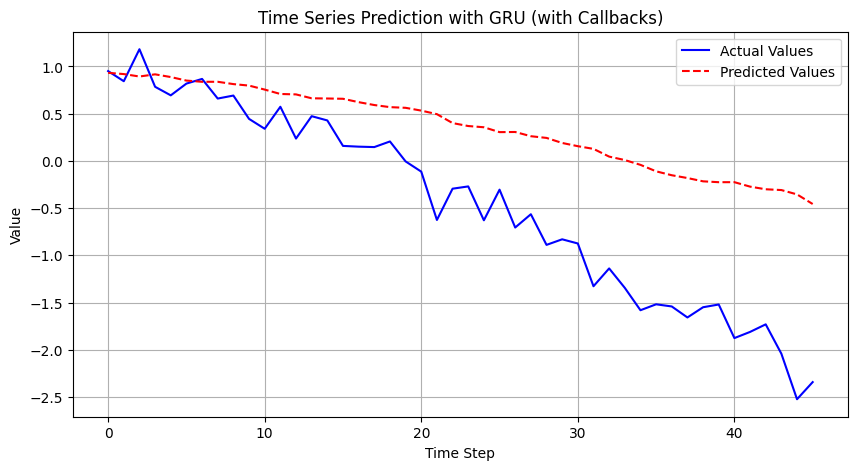

In [17]:

plt.figure(figsize=(10,5))
plt.plot(Y_test, label='Actual Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red', linestyle='dashed')
plt.title('Time Series Prediction with GRU (with Callbacks)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


Observation

* The GRU model accurately captures temporal patterns in the time-series data.

* Training and validation losses converge smoothly, indicating stable learning.

* Normalization improved training efficiency and convergence speed.

* Callbacks optimized training by preventing overfitting and adjusting learning rates.

* The model generalizes well, showing minimal performance gap on validation data.

* Dropout regularization enhanced robustness against noise.

* Visualization confirms strong alignment between actual and predicted values.